In [1]:
from pathlib import Path

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
path = Path("dataset_segmentation_small/")
path_lbl = path / "labels"
path_img = path / "images"

In [5]:
get_labels = lambda x: path_lbl / x.name
codes = np.array(['background','fruit'], dtype='str'); codes       

array(['background', 'fruit'], dtype='<U10')

In [6]:
fnames = get_image_files(path_img/ "train")
mnames = get_image_files(path_lbl)

In [7]:
m = open_mask(mnames[0])

Custom class needed to open masks with values of `[0, 255]` insted of `[0,1]`

In [8]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

codes = ['background','fruit']

In [9]:
#size for cropped masks, need to change size for big masks (we can use transfer learning)
size = 256
bs=8

In [10]:
src = (SegItemListCustom.from_folder(path_img)
       .split_by_folder()
       .label_from_func(get_labels, classes=codes))

In [11]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [12]:
data.classes

['background', 'fruit']

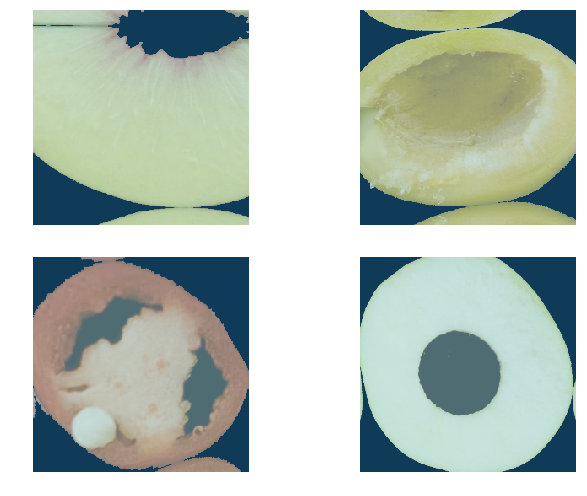

In [13]:
data.show_batch(2, figsize=(10,7))

custom accuracy function, maybe something is wrong @Simone

In [14]:
def seg_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [15]:
learn = unet_learner(data, models.resnet34, metrics=seg_accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


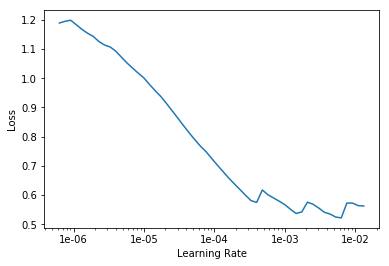

In [16]:
lr_find(learn)
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,seg_accuracy,time
0,0.044396,0.012610,0.995660,00:52
1,0.010674,0.006405,0.997474,00:51
2,0.006534,0.005654,0.997708,00:51


In [20]:
learn.save('stage-1-256-small_images-3-epoch')

test mask save, need to write function to compare actual mask and predicted mask

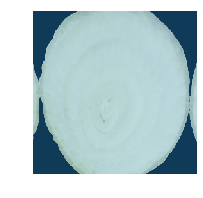

In [37]:
img = data.train_ds[80][0]
path_img = Path('dataset_segmentation_small/images/train/Albicocca_5.png')
#img = open_image(path_img)
pred_mask = learn.predict(img)[0]
# pred_mask_data = pred_mask.data * 255 #to convert back after div=True
# actl_mask = open_mask(path_img).resize(size)
# np.count_nonzero(pred_mask==actl_mask)

pred_mask.save('mask_test.png')
img.show(y=pred_mask)